In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self, NET_IN=4, NET_OUT=2):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(NET_IN, 64) # _, 64
#         self.dropout1 = nn.Dropout(0.2)
        
        self.layer2 = nn.Linear(64, 64) # 64, 128
#         self.dropout2 = nn.Dropout(0.2)
        
        self.layer_out = nn.Linear(64, NET_OUT) # 64, _
        
    def forward(self, x):
#         x = self.dropout1(F.relu(self.layer1(x)))
        x = F.relu(self.layer1(x))
#         x = self.dropout2(F.relu(self.layer2(x)))
        x = F.relu(self.layer2(x))
        x = self.layer_out(x)
        return x

import numpy as np

class memory():
    def __init__(self, mem_cap, state_len):
        # 使用np数组存储数据
        self.mem_cap = mem_cap
        self.state_len = state_len
        
        self.states = np.zeros([mem_cap, state_len], dtype = np.float32)
        self.next_states = np.zeros([mem_cap, state_len], dtype = np.float32)
        self.actions = np.zeros(mem_cap, dtype = np.int32)
        self.rewards = np.zeros(mem_cap, dtype = np.float32)
        
        self.mem_iter = 0
        self.train = False
       
    def store(self, state=None, next_state=None, action=None, reward=None):
        # 输入数据都是np数组[**6**]
        index = self.mem_iter
        self.states[index, :] = state
        self.next_states[index, :] = next_state
        self.actions[index] = action
        self.rewards[index] = reward
        self.mem_iter += 1
        if self.mem_iter == self.mem_cap:
            self.train = True
            self.mem_iter = 0
        else:
            self.train = False
        
    def get_train_data(self, batch_size):
        index = np.random.randint(0, self.mem_cap, batch_size)
        batch_states = self.states[index, :]
        batch_next_states = self.next_states[index, :]
        batch_rewards = self.rewards[index]
        batch_actions = self.actions[index]
        return batch_states, batch_next_states, batch_rewards, batch_actions
    
    def is_train(self):
        return self.train

def position_reward(env, x, theta):
    r1 = (env.x_threshold - abs(x))/env.x_threshold - 0.5
    r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
    reward = r1 + r2
    return reward

# DQN()
import gym
import torch
import numpy as np
class DQN():
    def __init__(self,
                 env_name='CartPole-v0',
                 mem_cap=500, 
                 epsilon=0.9,
                 gamma = 0.9,
                 lr=0.001,
                 learn_step=100,
                 device='cuda:0'):
        self.epsilon = epsilon
        self.device = device
        self.learn_step = learn_step
        
        self.env = gym.make(env_name)
#         self.env = gym.make(env_name).unwrapped
        self.state = self.env.reset()
        self.done = False
        num_actions = self.env.action_space.n
        state_len = self.env.observation_space.shape[0]
        
        self.mem = memory(mem_cap, state_len)
        
        self.net_eval, self.net_target = Net(state_len, num_actions).to(device), Net(state_len, num_actions).to(device)
        self.net_target.eval()
        self.loss_f = nn.MSELoss().to(device)
        self.optimizer = torch.optim.Adam(self.net_eval.parameters(), lr=lr)
        self.gamma = gamma
        self.learn_iter = 0
    
    def action(self, state=None):
        if np.random.rand() > self.epsilon:
            action = self.env.action_space.sample()
        else:
            self.net_eval.eval()
            state = torch.Tensor(state).float().to(self.device)[None, :]
            action = self.net_eval(state)[0,:].argmax().cpu().item()
        return action
    
    def store(self, state, next_state, action, reward):
        self.mem.store(state, next_state, action, reward)
        
    def step(self, action):
        next_state, time_reward, self.done, _ = self.env.step(action)
        x, x_dot, theta, theta_dot = next_state
        reward = position_reward(self.env, x, theta)
        self.store(self.state, next_state, action, reward)
        self.state = next_state
        return time_reward
        
    def is_train(self):
        return self.mem.is_train()
    
    def reset(self):
        self.state = self.env.reset()
        self.done = False
    
    def learn(self, batch_size=128):
        if (self.learn_iter + 1) % self.learn_step == 0:
            self.net_target.load_state_dict(self.net_eval.state_dict())
        
        batch_states, batch_next_states, batch_rewards, batch_actions = self.mem.get_train_data(batch_size = batch_size)
        
        batch_states = torch.Tensor(batch_states).float().to(self.device)
        batch_next_states = torch.Tensor(batch_next_states).float().to(self.device)
        batch_rewards = torch.Tensor(batch_rewards).float().to(self.device)
        batch_actions = torch.Tensor(batch_actions).long().to(self.device)
        
        self.net_eval.train()
        
        q_eval = self.net_eval(batch_states)[[i for i in range(batch_size)], batch_actions]
        q_next_max = self.net_target(batch_next_states).max(-1)[0].detach()
        q_target = batch_rewards + self.gamma * q_next_max
        loss = self.loss_f(q_eval, q_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.learn_iter += 1

ep 1000 reward 9.0
ep 2000 reward 9.0
ep 3000 reward 10.0
ep 4000 reward 10.0
ep 5000 reward 11.0
ep 6000 reward 16.0
ep 7000 reward 9.0
ep 8000 reward 10.0
ep 9000 reward 13.0
ep 10000 reward 13.0
ep 11000 reward 35.0
ep 12000 reward 32.0
ep 13000 reward 22.0
ep 14000 reward 52.0
ep 15000 reward 65.0
ep 16000 reward 33.0
ep 17000 reward 23.0
ep 18000 reward 29.0
ep 19000 reward 24.0
ep 20000 reward 39.0
ep 21000 reward 17.0
ep 22000 reward 17.0
ep 23000 reward 24.0
ep 24000 reward 80.0
ep 25000 reward 83.0
ep 26000 reward 200.0
ep 27000 reward 152.0
ep 28000 reward 200.0
ep 29000 reward 200.0
ep 30000 reward 200.0
ep 31000 reward 200.0
ep 32000 reward 200.0
ep 33000 reward 200.0
ep 34000 reward 200.0
ep 35000 reward 200.0
ep 36000 reward 200.0
ep 37000 reward 200.0
ep 38000 reward 200.0
ep 39000 reward 200.0
ep 40000 reward 200.0


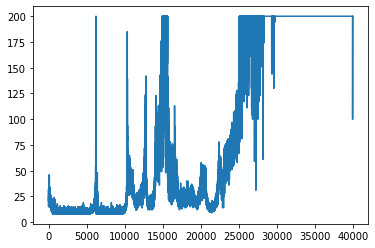

In [2]:
import matplotlib.pyplot as plt

def main():
    dqn = DQN()
    reward_list = []
    ep = 0
    while True:
        reward_ep = 0
        ep += 1
        while not dqn.done:
            if dqn.is_train():
                dqn.learn()
            time_reward = dqn.step(dqn.action(dqn.state))
            reward_ep += time_reward
        if ep % 1000 == 0:
            print('ep',ep,'reward',reward_ep)
        reward_list.append(reward_ep)
        dqn.reset()
        if ep == 40000:
            break
    torch.save(dqn.net_target.state_dict(),'ckpt-4w')
    return reward_list

reward_list = main()

plt.plot(reward_list)
plt.savefig("filename.png")
plt.show()